# Setting Up

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Dataset
We first get the dataset

In [25]:
df = pd.read_csv('mod_data_for_decision_tree.csv')
df

category_id  endorsement_count    created_time               author  \
0               96                184  11:14:58+00:00               Aquifn   
1               96                196  11:14:58+00:00               Aquifn   
2                5               1295  11:14:58+00:00               Aquifn   
3               53               4545  11:39:31+00:00            Ceasirius   
4               94                108  00:52:40+00:00                 Alex   
...            ...                ...             ...                  ...   
29777           96                 61  19:00:50+00:00             Hectiqal   
29778           96                300  19:05:04+00:00              maxiteo   
29779           54                  1  19:53:34+00:00          Sabbath6100   
29780           96                 63  20:09:17+00:00         lilebonymace   
29781           36                  8  21:00:25+00:00  lovespaceunderspice   

               uploaded_by  contains_adult_content  high  
0                   Aquifn                       0     1  
1                   Aquifn                       0     1  
2                   Aquifn                       1     1  
3                Ceasirius                       0     1  
4                evittalex                       0     1  
...                    ...                     ...   ...  
29777             Hectiqal                       0     0  
29778              maxiteo                       1     1  
29779       Scorpioelite91                       0     0  
29780         lilebonymace                       0     0  
29781  lovespaceunderspice                       0     0  

[29782 rows x 7 columns]

View some information regarding the dataset

In [26]:
df.groupby('high').describe()

category_id                                                      \
           count       mean        std  min   25%   50%   75%    max   
high                                                                   
0        16409.0  64.713755  27.383062  0.0  36.0  67.0  88.0  115.0   
1        13373.0  61.338219  26.938921  0.0  33.0  60.0  84.0  110.0   

     endorsement_count               ...                   \
                 count         mean  ...    75%       max   
high                                 ...                    
0              16409.0    33.542629  ...   52.0      99.0   
1              13373.0  1480.063561  ...  856.0  223850.0   

     contains_adult_content                                              
                      count      mean      std  min  25%  50%  75%  max  
high                                                                     
0                   16409.0  0.090377  0.28673  0.0  0.0  0.0  0.0  1.0  
1                   13373.0  0.160248  0.36685  0.0  0.0  0.0  0.0  1.0  

[2 rows x 24 columns]

In [27]:
df['high'].value_counts()

0    16409
1    13373
Name: high, dtype: int64

## Convert string into numbers

In [28]:
df['author'] = df['author'].astype('category')
df['uploaded_by'] = df['uploaded_by'].astype('category')

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df

category_id  endorsement_count    created_time  author  uploaded_by  \
0               96                184  11:14:58+00:00     543          326   
1               96                196  11:14:58+00:00     543          326   
2                5               1295  11:14:58+00:00     543          326   
3               53               4545  11:39:31+00:00    1396          775   
4               94                108  00:52:40+00:00     322         6289   
...            ...                ...             ...     ...          ...   
29777           96                 61  19:00:50+00:00    3406         1917   
29778           96                300  19:05:04+00:00   10847         7294   
29779           54                  1  19:53:34+00:00    6962         3937   
29780           96                 63  20:09:17+00:00   10702         7097   
29781           36                  8  21:00:25+00:00   10746         7161   

       contains_adult_content  high  
0                           0     1  
1                           0     1  
2                           1     1  
3                           0     1  
4                           0     1  
...                       ...   ...  
29777                       0     0  
29778                       1     1  
29779                       0     0  
29780                       0     0  
29781                       0     0  

[29782 rows x 7 columns]

## Treating outliers

Mods that have more than 1000 endorsements will be considered as outliers



In [29]:
cat_counts = df['category_id'].value_counts()
# Only accept mods from categories that have more than 300 entries
filtered_cat = cat_counts[cat_counts > 300]
safe_categories = filtered_cat.index.tolist()

df_filtered = df[df['category_id'].isin(safe_categories)]
# Filter out mods with more than 1000 endorsements
df_filtered = df_filtered[(df_filtered['endorsement_count'] <= 1000)]

df_filtered['high'].value_counts()

0    14206
1     9282
Name: high, dtype: int64

## Balancing the Dataset
To balance the distribution of samples between the two classes, oversampling will be used.

In [30]:
from dataset_preprocessor import perform_oversampling

print('Original data:')
print(df_filtered['high'].value_counts())

df_balanced = perform_oversampling(df_filtered)

print('-'*10)
print('After oversampling:')
print(df_balanced['high'].value_counts())

Original data:
0    14206
1     9282
Name: high, dtype: int64
----------
After oversampling:
0    14206
1    14206
Name: high, dtype: int64


## Train-test Split

In [31]:
from sklearn.model_selection import train_test_split

seed = 69420

df_main = df_balanced

# Only select extreme values
# df_main.drop(df_main[(df_main['endorsement_count'] > 20) & (df_main['endorsement_count'] < 200)].index, inplace=True)

y = df_main['high']
x = df_main.drop(['high', 'endorsement_count', 'created_time'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df_main['high'], random_state=seed)

# Remove label from feature
# x_train = x_train['high']

# # Merge the respective x and y into one DataFrame
# df_train = x_train
# df_train['high'] = y_train

# df_test = x_test
# df_test['high'] = y_test

# Training

In [32]:
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

Check hyperparameters

In [33]:
xgboost.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Training

Finding the best hyperparameter

In [34]:
# learning_rate_list = [0.02, 0.1, 0.2]
# max_depth_list = [10, 50, 100]
# n_estimators_list = [3000, 4000, 5000]
# subsample_list = [0.25, 0.5, 1]
# colsample_list = [0.25, 0.5, 1]

# params_dict = {"learning_rate": learning_rate_list,
#                "max_depth": max_depth_list,
#                "n_estimators": n_estimators_list,
#                "subsamples" : subsample_list,
#                "colsamples" : colsample_list
#                }

# num_combinations = 1
# for v in params_dict.values(): num_combinations *= len(v) 

# print('Possible combinations:', num_combinations)
# params_dict

In [35]:
# # https://www.kaggle.com/harsh1kumar/santander-trxn-pred-xgboost

# def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

# model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBClassifier(eval_metric='auc', use_label_encoder=False),
#                                 param_grid=params_dict,
#                                 cv=2,
#                                 scoring=my_roc_auc_score,
#                                 return_train_score=True,
#                                 verbose=2)

# model_xgboost_hp.fit(x, y)

In [36]:
# df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
# df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
#                                'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsamples', 'param_colsamples']]
# df_cv_results.sort_values(by='rank_test_score', inplace=True)
# df_cv_results

Create model

In [46]:
model_xgb = xgboost.XGBClassifier(
    eval_metric='auc',
    subsample = 1,
    n_estimators=300,
    max_depth=500,
    colsample_bytree=0.5,
    learning_rate=0.1
)

eval_set = [(x_train, y_train), (x_test, y_test)]

model_xgb.fit(
    x_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-auc:0.63381	validation_1-auc:0.64121
[1]	validation_0-auc:0.63381	validation_1-auc:0.64116
[2]	validation_0-auc:0.84806	validation_1-auc:0.78553
[3]	validation_0-auc:0.87397	validation_1-auc:0.79720
[4]	validation_0-auc:0.86488	validation_1-auc:0.79368
[5]	validation_0-auc:0.85516	validation_1-auc:0.78904
[6]	validation_0-auc:0.84573	validation_1-auc:0.78388
[7]	validation_0-auc:0.86685	validation_1-auc:0.79512
[8]	validation_0-auc:0.90166	validation_1-auc:0.81724
[9]	validation_0-auc:0.91824	validation_1-auc:0.82810


K:\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-auc:0.92868	validation_1-auc:0.83505
[11]	validation_0-auc:0.93587	validation_1-auc:0.84056
[12]	validation_0-auc:0.94149	validation_1-auc:0.84403
[13]	validation_0-auc:0.94493	validation_1-auc:0.84653
[14]	validation_0-auc:0.94713	validation_1-auc:0.84762
[15]	validation_0-auc:0.94830	validation_1-auc:0.84770
[16]	validation_0-auc:0.94762	validation_1-auc:0.84763
[17]	validation_0-auc:0.94825	validation_1-auc:0.84724
[18]	validation_0-auc:0.94988	validation_1-auc:0.84844
[19]	validation_0-auc:0.94996	validation_1-auc:0.84822
[20]	validation_0-auc:0.95116	validation_1-auc:0.84919
[21]	validation_0-auc:0.95199	validation_1-auc:0.84952
[22]	validation_0-auc:0.95631	validation_1-auc:0.85228
[23]	validation_0-auc:0.95673	validation_1-auc:0.85211
[24]	validation_0-auc:0.95657	validation_1-auc:0.85225
[25]	validation_0-auc:0.95713	validation_1-auc:0.85244
[26]	validation_0-auc:0.96025	validation_1-auc:0.85424
[27]	validation_0-auc:0.96036	validation_1-auc:0.85430
[28]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=500,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Evaluation

In [47]:
y_true = np.array(y_test.tolist())
y_pred = model_xgb.predict_proba(x_test)[:,1]
y_pred = np.where(y_pred > 0.5, 1, 0)   # Change values into 1s or 0s

y_pred

array([0, 1, 0, ..., 0, 0, 1])

Create confusion matrix

Text(33.0, 0.5, 'Truth')

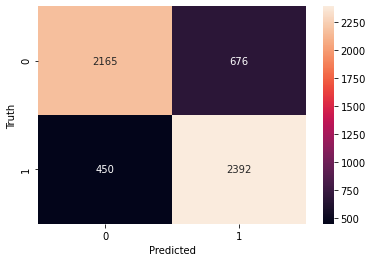

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      2841
           1       0.78      0.84      0.81      2842

    accuracy                           0.80      5683
   macro avg       0.80      0.80      0.80      5683
weighted avg       0.80      0.80      0.80      5683



In [50]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_pred)

See variable importance

In [51]:
columns = [c for c in x.columns]

df_var_imp = pd.DataFrame({"Variable": columns,
                           "Importance": model_xgb.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

Variable  Importance
3  contains_adult_content    0.859501
0             category_id    0.060696
2             uploaded_by    0.044162
1                  author    0.035641

Save the model

In [52]:
model_xgb.save_model('model_checkpoints/xgb/xgb_model.txt')

In [53]:
# model_xgb.load_model('model_checkpoints/xgb/xgb_model.txt')
# model_xgb.best_ntree_limit

## Test prediction

Perform a test prediction

In [54]:
# test_input = [53, 'GiantSweetroll', 'GiantSweetroll', 0]

# df = pd.DataFrame (columns=["category_id", "author", "uploaded_by", "contains_adult_content"])
# df.loc[len(df)] = test_input
# ds = tfdf.keras.pd_dataframe_to_tf_dataset(df)

# model.predict(ds).flatten()[0]